In [3]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [258]:
# built-in libraries
import os
import sys
from itertools import combinations
from collections import defaultdict
import time
import pprint
import copy
from functools import reduce

# external dependencies
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as onp
from tqdm.notebook import tqdm
import jax.numpy as jnp

import multidms
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Data Description

# Data Summary Stats

First load in the data

In [269]:
C19 = pd.read_csv("../data/CYP2/CYP2C19_data_bc_corrected.csv")
C9 = pd.read_csv("../data/CYP2/CYP2C9_data_bc.csv")
rename_map = {
    "variant" : "aa_substitutions"
}

func_score_df = pd.concat(
    [
        c19.assign(condition="C19"), 
        c9.assign(condition="C9")
    ]
).rename(rename_map,axis=1)

func_score_df = func_score_df[~func_score_df.aa_substitutions.str.contains("syn")]
func_score_df = func_score_df.assign(aa_substitutions = func_score_df.aa_substitutions.str.replace("X", "*"))
func_score_df = func_score_df.assign(log_fold_wa = onp.log2(func_score_df.weighted_average / func_score_df.wt_wa))
func_score_df

replicate  sort             barcode  weighted_average  total_reads  \
0           Rep1   1.0  AAAAAAAACTACGTTCCA          0.979031          352   
1           Rep1   1.0  AAAAAAAATCCTAGCCGT          0.637117          421   
2           Rep1   1.0  AAAAAAAATTTTGAAAGA          0.581670         1675   
3           Rep1   1.0  AAAAAAACTATTGACTTC          0.782963          262   
4           Rep1   1.0  AAAAAAATACAGGTTAAT          0.281605          747   
...          ...   ...                 ...               ...          ...   
149377      Rep3   NaN  TTTTTTTTGAAAGTCAAG          0.706138          188   
149378      Rep3   NaN  TTTTTTTTGCCAACGAAG          0.647242          166   
149379      Rep3   NaN  TTTTTTTTGTAATTCTTG          0.692603          103   
149380      Rep3   NaN  TTTTTTTTGTACGTACTT          0.496281          104   
149381      Rep3   NaN  TTTTTTTTTAATAGGCTG          0.602997          137   

            freq      type  med_nonsense     wt_wa  abundance_score  \
0       0.000013  missense      0.270414  0.900006         1.125517   
1       0.000013  missense      0.270414  0.900006         0.582444   
2       0.000054  missense      0.270414  0.900006         0.494377   
3       0.000012  missense      0.270414  0.900006         0.814096   
4       0.000068  nonsense      0.270414  0.900006         0.017776   
...          ...       ...           ...       ...              ...   
149377  0.000070  missense      0.423188  0.701742         1.015779   
149378  0.000065  missense      0.423188  0.701742         0.804345   
149379  0.000038  missense      0.423188  0.701742         0.967191   
149380  0.000044  missense      0.423188  0.701742         0.262400   
149381  0.000054  missense      0.423188  0.701742         0.645508   

       aa_substitutions start  position end condition  log_fold_wa  
0                 S162R     S       162   R       C19     0.121419  
1                 D373R     D       373   R       C19    -0.498378  
2                 D360K     D       360   K       C19    -0.629734  
3                  L71G     L        71   G       C19    -0.200991  
4                 E274*     E       274   X       C19    -1.676260  
...                 ...   ...       ...  ..       ...          ...  
149377            K247A     K       247   A        C9     0.009008  
149378            D191T     D       191   T        C9    -0.116636  
149379            Q193L     Q       193   L        C9    -0.018912  
149380            G332S     G       332   S        C9    -0.499785  
149381            K275G     K       275   G        C9    -0.218790  

[883130 rows x 16 columns]

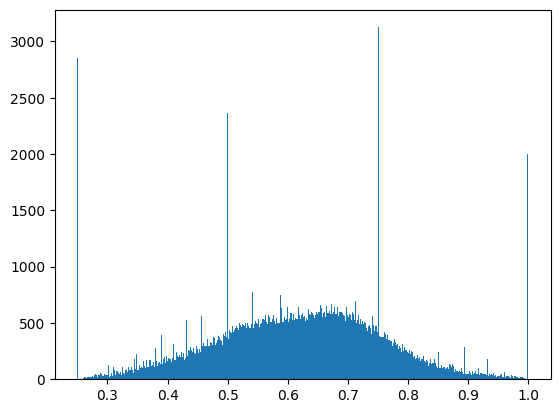

In [270]:

plt.hist(c9.weighted_average, bins=500)
plt.show()

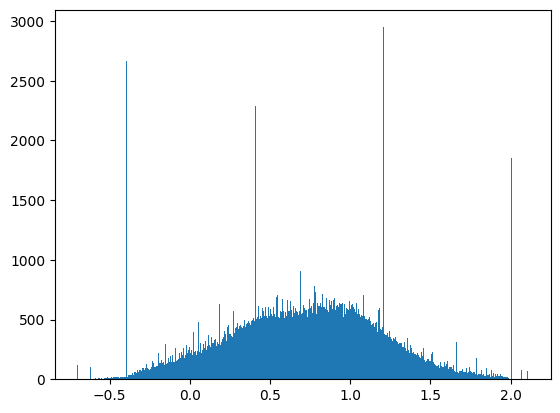

In [271]:
import numpy as np
plt.hist(c9.abundance_score, bins=500)
plt.show()

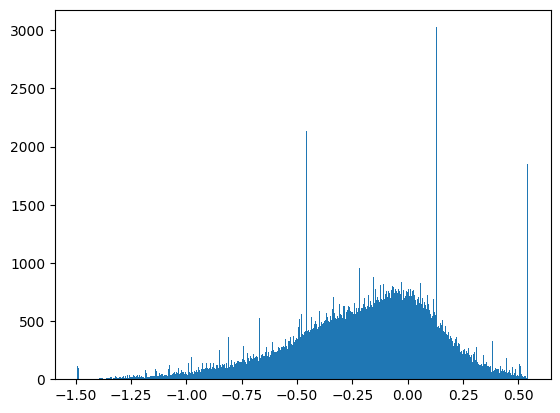

In [272]:
import numpy as np
plt.hist(np.log2(c9.weighted_average / c9.wt_wa), bins=500)
plt.show()

In [252]:
plt.c9.variant.value_counts()

H251G           249
C10L            214
S286G           192
N204G           191
I207G           185
               ... 
syn_1470C>T       1
I452Q             1
A103T             1
T130C             1
A477L             1
Name: variant, Length: 8809, dtype: int64

`med_nonsense` - is the weighted average for the stop codon
`wt_wa` - is the weighted average for the wildtype
`abundance_score` - is a score between 0 and 1 

In [15]:
c9.query("replicate == 'Rep3'").abundance_score.median()

0.7383365503369735

In [17]:
c9.describe()

weighted_average    total_reads          freq       position  \
count     149382.000000  149382.000000  1.493820e+05  149382.000000   
mean           0.617980     154.675456  7.796472e-05     238.909072   
std            0.148579     166.084963  6.464694e-05     137.806071   
min            0.250000       1.000000  2.859957e-07       2.000000   
25%            0.517745      25.000000  3.219578e-05     124.000000   
50%            0.623083     105.000000  6.161444e-05     237.000000   
75%            0.719505     229.000000  1.051567e-04     353.000000   
max            1.000000    2029.000000  7.470403e-04     490.000000   

        med_nonsense          wt_wa  abundance_score  
count  149382.000000  149382.000000    149382.000000  
mean        0.411958       0.697273         0.719755  
std         0.027299       0.008090         0.509868  
min         0.372729       0.685447        -0.701318  
25%         0.372729       0.685447         0.380446  
50%         0.423188       0.701742         0.730611  
75%         0.437047       0.703754         1.073248  
max         0.437047       0.703754         2.110753

Cleanup data for MultiDmsData Object instantiation

In [92]:
rename_map = {
    "weighted_avg_fold_change" : "func_score",
    "variant" : "aa_substitutions"
}

func_score_df = pd.concat(
    [
        c19.assign(condition="C19").assign(weighted_avg_fold_change = np.log2(c19.weighted_average / c19.wt_wa)), 
        c9.assign(condition="C9").assign(weighted_avg_fold_change = np.log2(c9.weighted_average / c9.wt_wa))
    ]
)[["variant", "weighted_avg_fold_change", "condition"]]
func_score_df.rename(rename_map,axis=1, inplace=True)
func_score_df

aa_substitutions  func_score condition
0                 S162R    0.121419       C19
1                 D373R   -0.498378       C19
2                 D360K   -0.629734       C19
3                  L71G   -0.200991       C19
4                 E274X   -1.676260       C19
...                 ...         ...       ...
149377            K247A    0.009008        C9
149378            D191T   -0.116636        C9
149379            Q193L   -0.018912        C9
149380            G332S   -0.499785        C9
149381            K275G   -0.218790        C9

[921323 rows x 3 columns]

In [93]:
func_score_df = func_score_df[~func_score_df.aa_substitutions.str.contains("syn")]

In [94]:
func_score_df = func_score_df.assign(aa_substitutions = func_score_df.aa_substitutions.str.replace("X", "*"))

In [95]:
func_score_df

aa_substitutions  func_score condition
0                 S162R    0.121419       C19
1                 D373R   -0.498378       C19
2                 D360K   -0.629734       C19
3                  L71G   -0.200991       C19
4                 E274*   -1.676260       C19
...                 ...         ...       ...
149377            K247A    0.009008        C9
149378            D191T   -0.116636        C9
149379            Q193L   -0.018912        C9
149380            G332S   -0.499785        C9
149381            K275G   -0.218790        C9

[883130 rows x 3 columns]

Intantiate `MultiDmsData` Object

In [96]:
mdms_data = multidms.MultiDmsData(
    func_score_df,
    reference = "C9",
    collapse_identical_variants = False,
    alphabet= multidms.AAS_WITHSTOP,
)

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [289]:
jnp.ones(shape=(1,))

Array([1.], dtype=float64)

In [291]:
jnp.array([5.])

Array([5.], dtype=float64)

In [297]:
def fit_wrapper(
    dataset,
    δ_huber = 1,
    λ_lasso_shift = 2e-5,
    λ_ridge_beta = 0,
    λ_ridge_shift = 0,
    λ_ridge_gamma = 0,
    data_idx = 0,
    epistatic_model = "Identity",
    output_activation = "Identity",
    lock_beta = False, 
    lock_C_ref = False,
    gamma_corrected = True,
    conditional_c = False,
    init_C_ref = 0.0,
    warmup_beta = False,
    tol=1e-3,
    num_training_steps = 10,
    iterations_per_step = 2000,
    save_model_at = [2000, 10000, 20000],
    PRNGKey=0
):
    
    fit_attributes = locals().copy()
    biophysical_model = {
        "Identity" : multidms.biophysical.identity_activation,
        "Sigmoid" : multidms.biophysical.sigmoidal_global_epistasis,
        "Perceptron" : multidms.biophysical.perceptron_global_epistasis,
        "Softplus" : multidms.biophysical.softplus_activation
    }
    
    
    imodel = multidms.MultiDmsModel(
        dataset,
        epistatic_model=biophysical_model[fit_attributes['epistatic_model']],
        output_activation=biophysical_model[fit_attributes['output_activation']],
        conditional_c=fit_attributes['conditional_c'],
        gamma_corrected=fit_attributes['gamma_corrected'],
        init_C_ref=fit_attributes['init_C_ref'],
        PRNGKey=PRNGKey
    )

    if fit_attributes["warmup_beta"]:
        imodel.fit_reference_beta()

    lock_params = {}
    if fit_attributes["lock_beta"]:
        lock_params["β"] = imodel.params["β"]

    if fit_attributes["lock_C_ref"] != False:
        lock_params["C_ref"] = jnp.array([fit_attributes["lock_C_ref"]])

    fit_attributes['step_loss'] = onp.zeros(num_training_steps)
    print(f"running:")
    pprint.pprint(fit_attributes)

    total_iterations = 0

    for training_step in range(num_training_steps):

        start = time.time()
        imodel.fit(
            lasso_shift = fit_attributes['λ_lasso_shift'],
            λ_ridge_shift = fit_attributes['λ_ridge_shift'],
            λ_ridge_beta = fit_attributes['λ_ridge_beta'],
            λ_ridge_gamma = fit_attributes['λ_ridge_beta'],
            maxiter=iterations_per_step, 
            tol=tol,
            δ=fit_attributes["δ_huber"],
            lock_params=lock_params
        )
        end = time.time()

        fit_time = round(end - start)
        total_iterations += iterations_per_step
        
        if onp.isnan(float(imodel.loss)):
            break
            
        fit_attributes['step_loss'][training_step] = float(imodel.loss)

        print(
            f"training_step {training_step}/{num_training_steps}, Loss: {imodel.loss}, Time: {fit_time} Seconds",
            flush=True
        )

        if total_iterations in save_model_at:
            fit_attributes[f"model_{total_iterations}"] = copy.copy(imodel)
              
    fit_series = pd.Series(fit_attributes).to_frame().T
            
    return fit_series

In [99]:
fit_params = {
    'epistatic_model' : "Identity",
    'output_activation' : "Identity",
    'warmup_beta':True,
    'save_model_at':[2000, 10000],
    'num_training_steps': 10,
    'iterations_per_step': 1000
}
start_t = time.time()
model = fit_wrapper(mdms_data, **fit_params)
end_t = time.time()

print(f"Done")


running:
{'PRNGKey': 0,
 'conditional_c': False,
 'data_idx': 0,
 'dataset': <multidms.data.MultiDmsData object at 0x7f8653cca4d0>,
 'epistatic_model': 'Identity',
 'gamma_corrected': True,
 'init_C_ref': 0.0,
 'iterations_per_step': 1000,
 'lock_C_ref': False,
 'lock_beta': False,
 'num_training_steps': 10,
 'output_activation': 'Identity',
 'save_model_at': [2000, 10000],
 'step_loss': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'tol': 0.001,
 'warmup_beta': True,
 'δ_huber': 1,
 'λ_lasso_shift': 2e-05,
 'λ_ridge_beta': 1e-06,
 'λ_ridge_gamma': 0.001,
 'λ_ridge_shift': 1e-06}
training_step 0/10, Loss: 0.13586842588093231, Time: 165 Seconds
training_step 1/10, Loss: 0.1274206071206851, Time: 160 Seconds
training_step 2/10, Loss: 0.12286145522099133, Time: 160 Seconds
training_step 3/10, Loss: 0.12002683388572487, Time: 160 Seconds
training_step 4/10, Loss: 0.12002478903810307, Time: 10 Seconds
training_step 5/10, Loss: 0.12002280533404952, Time: 9 Seconds
training_step 6/10, Los

In [100]:
model

dataset δ_huber λ_lasso_shift  \
0  <multidms.data.MultiDmsData object at 0x7f8653...       1       0.00002   

  λ_ridge_beta λ_ridge_shift λ_ridge_gamma data_idx epistatic_model  \
0     0.000001      0.000001         0.001        0        Identity   

  output_activation lock_beta  ... init_C_ref warmup_beta    tol  \
0          Identity     False  ...        0.0        True  0.001   

  num_training_steps iterations_per_step  save_model_at PRNGKey  \
0                 10                1000  [2000, 10000]       0   

                                           step_loss  \
0  [0.13586842588093231, 0.1274206071206851, 0.12...   

                                          model_2000  \
0  <multidms.model.MultiDmsModel object at 0x7f86...   

                                         model_10000  
0  <multidms.model.MultiDmsModel object at 0x7f86...  

[1 rows x 23 columns]

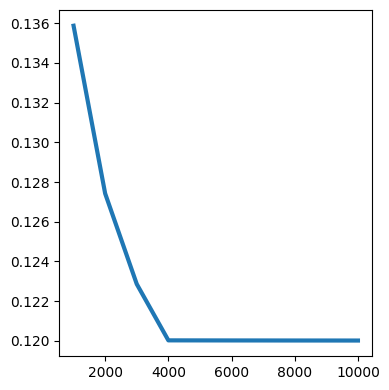

In [107]:
fig, ax = plt.subplots(1,figsize=[4,4])
ax.plot(
    [1000 * (s+1) for s in range(len(model.step_loss.values[0]))],
    model.step_loss.values[0],
    lw=3
)
plt.tight_layout()
plt.show()

This flatline loss is because the tolerance was low

In [103]:
import matplotlib.colors
matplotlib.colors.to_rgb('#009E73')

(0.0, 0.6196078431372549, 0.45098039215686275)

In [104]:
model.loc[0, "model_10000"].data.condition_colors = {
    'C19': (0.0, 0.4470588235294118, 0.6980392156862745), 
    'C9': (0.0, 0.6196078431372549, 0.45098039215686275)
}

In [141]:
model.loc[0, "model_10000"].mut_shift_plot(include_beta=True)

/home/jgallowa/miniconda3/envs/multidms_toml/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)

In [119]:
mut_df = model.loc[0, "model_10000"].mutations_df
mut_df

mutation wts  sites muts  times_seen_C19  times_seen_C9         β  \
0         D2A   D      2    A            63.0           27.0 -0.100521   
1         D2C   D      2    C            28.0            9.0  0.159539   
2         D2E   D      2    E            48.0           24.0 -0.002968   
3         D2F   D      2    F            26.0            8.0 -0.247687   
4         D2G   D      2    G           412.0           72.0 -0.050154   
...       ...  ..    ...  ...             ...            ...       ...   
9390    V490R   V    490    R             7.0           31.0 -0.042763   
9391    V490S   V    490    S            14.0           26.0 -0.094422   
9392    V490T   V    490    T             7.0            6.0  0.085607   
9393    V490W   V    490    W             0.0            3.0 -0.165977   
9394    V490Y   V    490    Y             0.0            3.0 -0.068836   

         S_C19  
0     0.000075  
1    -0.000000  
2     0.000000  
3     0.000000  
4     0.143896  
...        ...  
9390  0.000000  
9391  0.000000  
9392  0.000000  
9393  0.000000  
9394  0.000000  

[9395 rows x 8 columns]

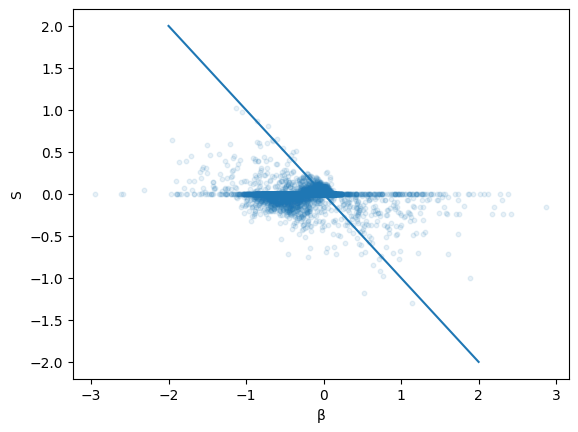

In [131]:
fig, ax = plt.subplots(1)
ax.scatter(mut_df.β, mut_df.S_C19, alpha=0.1, s=10.5)
ax.set_xlabel("β")
ax.set_ylabel("S")

ax.plot([-2, 2], [2,-2])

In [132]:
params = model.loc[0, "model_10000"].params
params

{'C_C19': Array([0.], dtype=float64),
 'C_C9': Array([0.], dtype=float64),
 'C_ref': Array([-0.01485392], dtype=float64),
 'S_C19': Array([ 7.45922821e-05, -0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00], dtype=float64),
 'S_C9': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float64),
 'α': {'ghost_param': Array([0.], dtype=float64)},
 'β': Array([-0.10052118,  0.15953905, -0.00296752, ...,  0.08560739,
        -0.1659773 , -0.06883599], dtype=float64),
 'γ_C19': Array([-0.51965878], dtype=float64),
 'γ_C9': Array([0.], dtype=float64)}

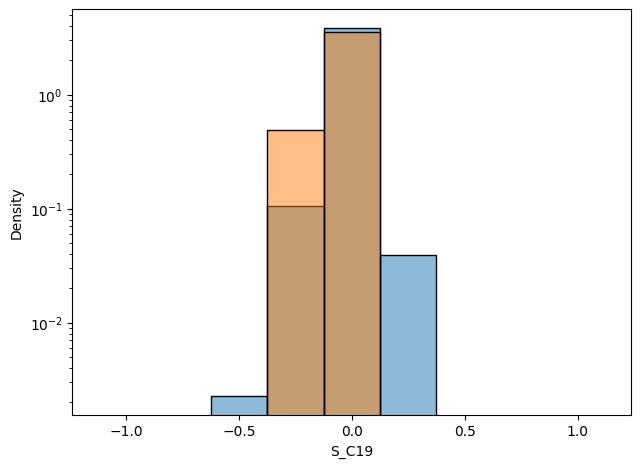

In [137]:
fig, ax = plt.subplots(1)
model.loc[0, "model_10000"].plot_param_hist("S_C19", ax=ax, show=False)
ax.set_yscale("log")
plt.show()

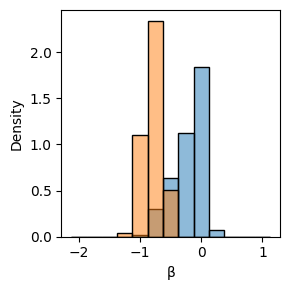

<AxesSubplot: xlabel='β', ylabel='Density'>

In [134]:
model.loc[0, "model_10000"].plot_param_hist("β")

0. Email Gabe about the functional scores being used. We like log fold change because of it balance (wt at zero) properties
1. Fit and scatter the training accuracy of beta's to reference (should be damn near perfect)
2. Try a few different regularization strengths
3. Distributions of Beta / Shift (stop v non stop)
4. Do we expect there to be experiemntal bias? i.e. do we need gamma? currently, it's fitting as if that's the case.

Fit model using abundance score. Fixing the c_ref at 1.0 because the wildtype latent prediction should be 1

In [159]:
rename_map = {
    "abundance_score" : "func_score",
    "variant" : "aa_substitutions"
}

func_score_df = pd.concat(
    [
        c19.assign(condition="C19"), 
        c9.assign(condition="C9")
    ]
)[["variant", "abundance_score", "condition"]]
func_score_df.rename(rename_map,axis=1, inplace=True)
func_score_df = func_score_df[~func_score_df.aa_substitutions.str.contains("syn")]
func_score_df = func_score_df.assign(aa_substitutions = func_score_df.aa_substitutions.str.replace("X", "*"))
func_score_df

aa_substitutions  func_score condition
0                 S162R    1.125517       C19
1                 D373R    0.582444       C19
2                 D360K    0.494377       C19
3                  L71G    0.814096       C19
4                 E274*    0.017776       C19
...                 ...         ...       ...
149377            K247A    1.015779        C9
149378            D191T    0.804345        C9
149379            Q193L    0.967191        C9
149380            G332S    0.262400        C9
149381            K275G    0.645508        C9

[883130 rows x 3 columns]

In [161]:
mdms_data_abundance_target = multidms.MultiDmsData(
    func_score_df,
    reference = "C9",
    collapse_identical_variants = False,
    alphabet= multidms.AAS_WITHSTOP,
    verbose=True
)

inferring site map for C19
inferring site map for C9
INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Converting mutations for C19


Converting mutations for C9
is reference, skipping


In [162]:
mdms_data_abundance_target.condition_colors = {
    'C19': (0.0, 0.4470588235294118, 0.6980392156862745), 
    'C9': (0.0, 0.6196078431372549, 0.45098039215686275)
}

Try Fitting the reference beta's

In [164]:
fit_params = {
    'epistatic_model' : "Identity",
    'output_activation' : "Identity",
    'lock_C_ref' : 1,
    'gamma_corrected' : False,
    'warmup_beta':False,
    'save_model_at':[2000],
    'num_training_steps': 10,
    'iterations_per_step': 200
}
start_t = time.time()
abundance_model = fit_wrapper(mdms_data_abundance_target, **fit_params)
end_t = time.time()

print(f"Done")

running:
{'PRNGKey': 0,
 'conditional_c': False,
 'data_idx': 0,
 'dataset': <multidms.data.MultiDmsData object at 0x7f864c4748b0>,
 'epistatic_model': 'Identity',
 'gamma_corrected': False,
 'init_C_ref': 0.0,
 'iterations_per_step': 200,
 'lock_C_ref': 1,
 'lock_beta': False,
 'num_training_steps': 10,
 'output_activation': 'Identity',
 'save_model_at': [2000],
 'step_loss': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'tol': 0.001,
 'warmup_beta': False,
 'δ_huber': 1,
 'λ_lasso_shift': 2e-05,
 'λ_ridge_beta': 1e-06,
 'λ_ridge_gamma': 0.001,
 'λ_ridge_shift': 1e-06}
training_step 0/10, Loss: 1.0355141782190596, Time: 41 Seconds
training_step 1/10, Loss: 0.9653578264195919, Time: 38 Seconds
training_step 2/10, Loss: 0.91456095731718, Time: 37 Seconds
training_step 3/10, Loss: 0.8705098469930741, Time: 37 Seconds
training_step 4/10, Loss: 0.8288784957553758, Time: 37 Seconds
training_step 5/10, Loss: 0.7870397229759227, Time: 37 Seconds
training_step 6/10, Loss: 0.753530993456896

/home/jgallowa/Projects/multidms/multidms/model.py:622: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/jgallowa/miniconda3/envs/multidms_toml/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


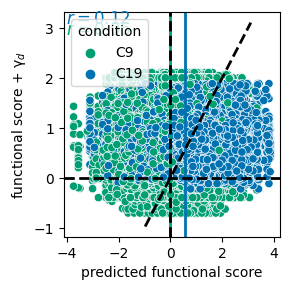

<AxesSubplot: xlabel='predicted functional score', ylabel='functional score + γ$_{d}$'>

In [167]:
abundance_model.loc[0, "model_2000"].plot_pred_accuracy(legend=False)

## Fit a single homolog with data barcode aggregated 

In [260]:
rename_map = {
    "abundance_score" : "func_score",
    "variant" : "aa_substitutions"
}

func_score_df = c9.assign(condition="C9")[["variant", "abundance_score", "condition"]]
func_score_df.rename(rename_map,axis=1, inplace=True)
func_score_df = func_score_df[~func_score_df.aa_substitutions.str.contains("syn")]
func_score_df = func_score_df.assign(aa_substitutions = func_score_df.aa_substitutions.str.replace("X", "*"))
func_score_df

aa_substitutions  func_score condition
0                 S115F    0.862504        C9
1                 N116G    0.890550        C9
2                  E92W    1.083038        C9
3                 V479D    1.130881        C9
4                 S286R    1.475284        C9
...                 ...         ...       ...
149377            K247A    1.015779        C9
149378            D191T    0.804345        C9
149379            Q193L    0.967191        C9
149380            G332S    0.262400        C9
149381            K275G    0.645508        C9

[143170 rows x 3 columns]

In [261]:
mdms_data_abundance_target = multidms.MultiDmsData(
    func_score_df,
    reference = "C9",
    collapse_identical_variants = "mean",
    alphabet= multidms.AAS_WITHSTOP,
    verbose=True
)

inferring site map for C9
INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Converting mutations for C9
is reference, skipping


In [262]:
mdms_data_abundance_target.condition_colors = {
    'C9': (0.0, 0.6196078431372549, 0.45098039215686275)
}

In [263]:
model = multidms.MultiDmsModel(
    mdms_data_abundance_target,
    epistatic_model=multidms.biophysical.identity_activation,
    output_activation=multidms.biophysical.identity_activation,
    gamma_corrected=False,
    init_C_ref=1.0
)

In [264]:
model.fit_reference_beta()

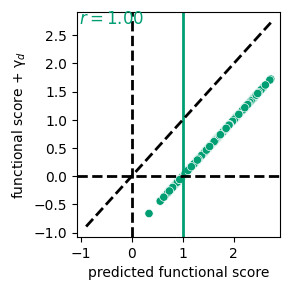

<AxesSubplot: xlabel='predicted functional score', ylabel='functional score + γ$_{d}$'>

In [265]:
model.plot_pred_accuracy(legend=False)

Try Fitting the reference beta's

In [202]:
fit_params = {
    'epistatic_model' : "Identity",
    'output_activation' : "Identity",
    'lock_C_ref' : 1,
    'gamma_corrected' : False,
    'warmup_beta':False,
    'save_model_at':[1000],
    'num_training_steps': 10,
    'iterations_per_step': 100,
    'tol' : 1e-6
}
start_t = time.time()
abundance_model = fit_wrapper(mdms_data_abundance_target, **fit_params)
end_t = time.time()

print(f"Done")

running:
{'PRNGKey': 0,
 'conditional_c': False,
 'data_idx': 0,
 'dataset': <multidms.data.MultiDmsData object at 0x7f839c2bab90>,
 'epistatic_model': 'Identity',
 'gamma_corrected': False,
 'init_C_ref': 0.0,
 'iterations_per_step': 100,
 'lock_C_ref': 1,
 'lock_beta': False,
 'num_training_steps': 10,
 'output_activation': 'Identity',
 'save_model_at': [1000],
 'step_loss': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'tol': 1e-06,
 'warmup_beta': False,
 'δ_huber': 1,
 'λ_lasso_shift': 2e-05,
 'λ_ridge_beta': 0,
 'λ_ridge_gamma': 0,
 'λ_ridge_shift': 0}
training_step 0/10, Loss: 0.001635833501230489, Time: 3 Seconds
training_step 1/10, Loss: 0.0016358335024661765, Time: 2 Seconds
training_step 2/10, Loss: 0.001635833503701717, Time: 2 Seconds
training_step 3/10, Loss: 0.0016358335049371099, Time: 2 Seconds
training_step 4/10, Loss: 0.0016358335061723557, Time: 2 Seconds
training_step 5/10, Loss: 0.0016358335074074543, Time: 2 Seconds
training_step 6/10, Loss: 0.001635833508642

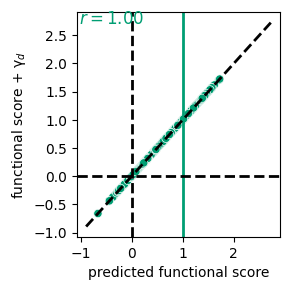

<AxesSubplot: xlabel='predicted functional score', ylabel='functional score + γ$_{d}$'>

In [203]:
abundance_model.loc[0, "model_1000"].plot_pred_accuracy(legend=False)

## Single homolog, no barcode aggregation

In [229]:
mdms_data_abundance_target = multidms.MultiDmsData(
    func_score_df,
    reference = "C9",
    collapse_identical_variants = False,
    alphabet= multidms.AAS_WITHSTOP,
    verbose=True
)

inferring site map for C9
INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Converting mutations for C9
is reference, skipping


In [230]:
mdms_data_abundance_target.condition_colors = {
    'C9': (0.0, 0.6196078431372549, 0.45098039215686275)
}

In [226]:
fit_params = {
    'epistatic_model' : "Identity",
    'output_activation' : "Identity",
    'lock_C_ref' : False,
    'gamma_corrected' : False,
    'warmup_beta':False,
    'save_model_at':[20000],
    'num_training_steps': 10,
    'iterations_per_step': 2000,
    'tol' : 1e-8
}
start_t = time.time()
model = fit_wrapper(data, **fit_params)
end_t = time.time()

print(f"Done")

running:
{'PRNGKey': 0,
 'conditional_c': False,
 'data_idx': 0,
 'dataset': <multidms.data.MultiDmsData object at 0x7f701038d900>,
 'epistatic_model': 'Identity',
 'gamma_corrected': False,
 'init_C_ref': 0.0,
 'iterations_per_step': 2000,
 'lock_C_ref': 1,
 'lock_beta': False,
 'num_training_steps': 10,
 'output_activation': 'Identity',
 'save_model_at': [20000],
 'step_loss': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'tol': 1e-08,
 'warmup_beta': False,
 'δ_huber': 1,
 'λ_lasso_shift': 2e-05,
 'λ_ridge_beta': 0,
 'λ_ridge_gamma': 0,
 'λ_ridge_shift': 0}
training_step 0/10, Loss: 0.08816168114603759, Time: 6 Seconds
training_step 1/10, Loss: 0.08816168114605985, Time: 3 Seconds
training_step 2/10, Loss: 0.08816168114608211, Time: 3 Seconds
training_step 3/10, Loss: 0.08816168114610436, Time: 3 Seconds
training_step 4/10, Loss: 0.08816168114612662, Time: 3 Seconds
training_step 5/10, Loss: 0.08816168114614888, Time: 3 Seconds
training_step 6/10, Loss: 0.08816168114617112, Time

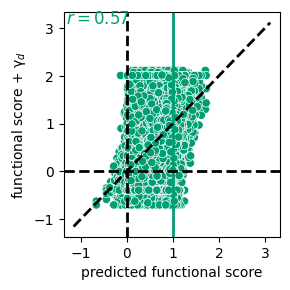

<AxesSubplot: xlabel='predicted functional score', ylabel='functional score + γ$_{d}$'>

In [227]:
abundance_model.loc[0, "model_20000"].plot_pred_accuracy(legend=False)

## Same thing, but with log fold weighted average as the target

In [274]:
func_score_df

replicate  sort             barcode  weighted_average  total_reads  \
0           Rep1   1.0  AAAAAAAACTACGTTCCA          0.979031          352   
1           Rep1   1.0  AAAAAAAATCCTAGCCGT          0.637117          421   
2           Rep1   1.0  AAAAAAAATTTTGAAAGA          0.581670         1675   
3           Rep1   1.0  AAAAAAACTATTGACTTC          0.782963          262   
4           Rep1   1.0  AAAAAAATACAGGTTAAT          0.281605          747   
...          ...   ...                 ...               ...          ...   
149377      Rep3   NaN  TTTTTTTTGAAAGTCAAG          0.706138          188   
149378      Rep3   NaN  TTTTTTTTGCCAACGAAG          0.647242          166   
149379      Rep3   NaN  TTTTTTTTGTAATTCTTG          0.692603          103   
149380      Rep3   NaN  TTTTTTTTGTACGTACTT          0.496281          104   
149381      Rep3   NaN  TTTTTTTTTAATAGGCTG          0.602997          137   

            freq      type  med_nonsense     wt_wa  abundance_score  \
0       0.000013  missense      0.270414  0.900006         1.125517   
1       0.000013  missense      0.270414  0.900006         0.582444   
2       0.000054  missense      0.270414  0.900006         0.494377   
3       0.000012  missense      0.270414  0.900006         0.814096   
4       0.000068  nonsense      0.270414  0.900006         0.017776   
...          ...       ...           ...       ...              ...   
149377  0.000070  missense      0.423188  0.701742         1.015779   
149378  0.000065  missense      0.423188  0.701742         0.804345   
149379  0.000038  missense      0.423188  0.701742         0.967191   
149380  0.000044  missense      0.423188  0.701742         0.262400   
149381  0.000054  missense      0.423188  0.701742         0.645508   

       aa_substitutions start  position end condition  log_fold_wa  
0                 S162R     S       162   R       C19     0.121419  
1                 D373R     D       373   R       C19    -0.498378  
2                 D360K     D       360   K       C19    -0.629734  
3                  L71G     L        71   G       C19    -0.200991  
4                 E274*     E       274   X       C19    -1.676260  
...                 ...   ...       ...  ..       ...          ...  
149377            K247A     K       247   A        C9     0.009008  
149378            D191T     D       191   T        C9    -0.116636  
149379            Q193L     Q       193   L        C9    -0.018912  
149380            G332S     G       332   S        C9    -0.499785  
149381            K275G     K       275   G        C9    -0.218790  

[883130 rows x 16 columns]

In [298]:
data = multidms.MultiDmsData(
    func_score_df.rename({"log_fold_wa":"func_score"}, axis=1).query("condition == 'C9'"),
    reference = "C9",
    collapse_identical_variants = False,
    alphabet= multidms.AAS_WITHSTOP,
    verbose=True
)

inferring site map for C9
INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Converting mutations for C9
is reference, skipping


In [299]:
data.condition_colors = {
    'C9': (0.0, 0.6196078431372549, 0.45098039215686275)
}

In [300]:
fit_params = {
    'epistatic_model' : "Identity",
    'output_activation' : "Identity",
    'lock_C_ref' : 0.,
    'gamma_corrected' : False,
    'warmup_beta':False,
    'save_model_at':[10000],
    'num_training_steps': 10,
    'iterations_per_step': 1000,
    'tol' : 1e-8
}
start_t = time.time()
fit = fit_wrapper(data, **fit_params)
end_t = time.time()

print(f"Done")

running:
{'PRNGKey': 0,
 'conditional_c': False,
 'data_idx': 0,
 'dataset': <multidms.data.MultiDmsData object at 0x7f844068bf10>,
 'epistatic_model': 'Identity',
 'gamma_corrected': False,
 'init_C_ref': 0.0,
 'iterations_per_step': 1000,
 'lock_C_ref': 0.0,
 'lock_beta': False,
 'num_training_steps': 10,
 'output_activation': 'Identity',
 'save_model_at': [10000],
 'step_loss': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'tol': 1e-08,
 'warmup_beta': False,
 'δ_huber': 1,
 'λ_lasso_shift': 2e-05,
 'λ_ridge_beta': 0,
 'λ_ridge_gamma': 0,
 'λ_ridge_shift': 0}
training_step 0/10, Loss: 0.051144307444435017, Time: 7 Seconds
training_step 1/10, Loss: 0.050630412609427584, Time: 5 Seconds
training_step 2/10, Loss: 0.05063089172844228, Time: 5 Seconds
training_step 3/10, Loss: 0.050630506629051455, Time: 5 Seconds
training_step 4/10, Loss: 0.050630546679541207, Time: 4 Seconds
training_step 5/10, Loss: 0.050630546679578864, Time: 3 Seconds
training_step 6/10, Loss: 0.0506305466796165

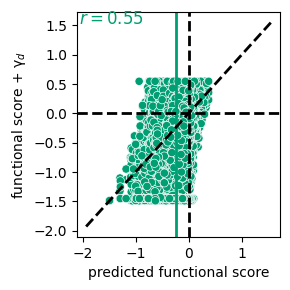

<AxesSubplot: xlabel='predicted functional score', ylabel='functional score + γ$_{d}$'>

In [301]:
fit.loc[0, "model_10000"].plot_pred_accuracy(legend=False)

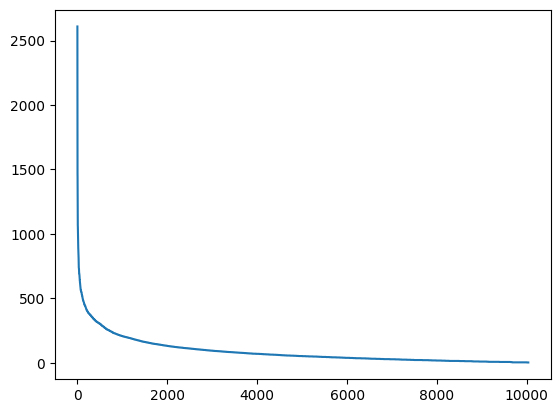

In [304]:
plt.plot(func_score_df.aa_substitutions.value_counts().values)

In [319]:
subs = func_score_df.aa_substitutions.value_counts()[8000:8050].index
subs.values

array(['C13F', 'D46I', 'Y243C', 'S343E', 'G25W', 'V479N', 'G442M',
       'L201H', 'L453K', 'R333N', 'N107T', 'L208A', 'L245W', 'K72L',
       'P33N', 'M339D', 'T469W', 'I74P', 'R333C', 'F295*', 'I207*',
       'T34*', 'M240K', 'E199V', 'K315T', 'F187K', 'T470E', 'V472P',
       'L395H', 'S53W', 'N218E', 'F448T', 'G442D', 'A297F', 'M345D',
       'H411C', 'P31W', 'Y347K', 'A477C', 'K399I', 'N196I', 'F114A',
       'F419W', 'S242Q', 'F114W', 'P402I', 'S303N', 'T159H', 'E444N',
       'N196C'], dtype=object)

In [320]:
subs_fs = func_score_df.query(f"aa_substitutions.isin({list(subs)})")
subs_fs

replicate  sort             barcode  weighted_average  total_reads  \
3086        Rep1   1.0  AACTCTCACCAGTGCTGA          0.530976          760   
3967        Rep1   1.0  AAGCTATGGATCTAGTTA          0.989781          903   
4396        Rep1   1.0  AAGTAGTTCACCGTATCA          0.862333          543   
6168        Rep1   1.0  AATGTTTTTTTCGGAATA          0.496023          598   
7799        Rep1   1.0  ACAGCGTTCAACCTCATG          0.295279          507   
...          ...   ...                 ...               ...          ...   
147938      Rep3   NaN  TTTAGATAAGTCTAAGGG          0.548185           61   
148174      Rep3   NaN  TTTCAAGAACCGGATAAG          0.398334           13   
148444      Rep3   NaN  TTTCTCCATTATCCGTTA          0.710813          375   
148480      Rep3   NaN  TTTCTGCGCTAACGATTG          0.475679          197   
148906      Rep3   NaN  TTTTACATCTTTGTACTT          0.611048          624   

            freq      type  med_nonsense     wt_wa  abundance_score  \
3086    0.000025  missense      0.270414  0.900006         0.413858   
3967    0.000034  missense      0.270414  0.900006         1.142593   
4396    0.000020  missense      0.270414  0.900006         0.940162   
6168    0.000020  missense      0.270414  0.900006         0.358341   
7799    0.000044  nonsense      0.270414  0.900006         0.039494   
...          ...       ...           ...       ...              ...   
147938  0.000025  missense      0.423188  0.701742         0.448735   
148174  0.000006  nonsense      0.423188  0.701742        -0.089227   
148444  0.000137  missense      0.423188  0.701742         1.032561   
148480  0.000087  missense      0.423188  0.701742         0.188440   
148906  0.000247  missense      0.423188  0.701742         0.674409   

       aa_substitutions start  position end condition  log_fold_wa  
3086               D46I     D        46   I       C19    -0.761289  
3967               C13F     C        13   F       C19     0.137175  
4396              L245W     L       245   W       C19    -0.061690  
6168              M240K     M       240   K       C19    -0.859529  
7799               T34*     T        34   X       C19    -1.607855  
...                 ...   ...       ...  ..       ...          ...  
147938            M345D     M       345   D        C9    -0.356278  
148174            F295*     F       295   X        C9    -0.816964  
148444            N218E     N       218   E        C9     0.018527  
148480            H411C     H       411   C        C9    -0.560953  
148906            K315T     K       315   T        C9    -0.199657  

[850 rows x 16 columns]

<AxesSubplot: xlabel='aa_substitutions', ylabel='abundance_score'>

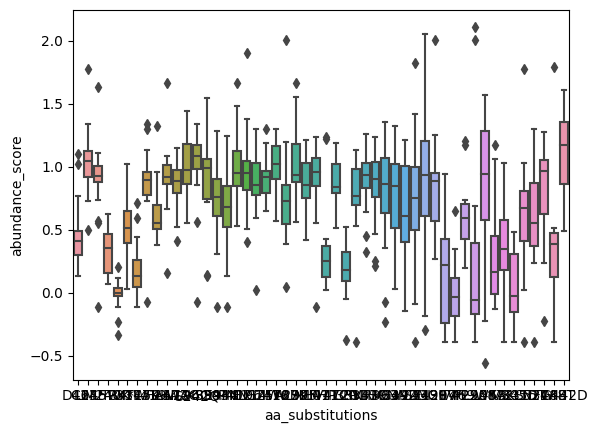

In [321]:
import seaborn as sns
sns.boxplot(subs_fs, x="aa_substitutions", y="abundance_score")

## Full Fit with abundance target

In [330]:
data = multidms.MultiDmsData(
    func_score_df.rename({"abundance_score":"func_score"}, axis=1),
    reference = "C9",
    collapse_identical_variants = False,
    alphabet= multidms.AAS_WITHSTOP,
    verbose=True
)

inferring site map for C19
inferring site map for C9
INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Converting mutations for C19


Converting mutations for C9
is reference, skipping


In [331]:
data.condition_colors = {
    'C19': (0.0, 0.4470588235294118, 0.6980392156862745), 
    'C9': (0.0, 0.6196078431372549, 0.45098039215686275)
}

In [332]:
fit_params = {
    'epistatic_model' : "Identity",
    'output_activation' : "Identity",
    'lock_C_ref' : 1.,
    'gamma_corrected' : False,
    'warmup_beta':False,
    'save_model_at':[20000],
    'num_training_steps': 20,
    'iterations_per_step': 1000,
    'tol' : 1e-6
}
start_t = time.time()
fit = fit_wrapper(data, **fit_params)
end_t = time.time()

print(f"Done")

running:
{'PRNGKey': 0,
 'conditional_c': False,
 'data_idx': 0,
 'dataset': <multidms.data.MultiDmsData object at 0x7f6effe84bb0>,
 'epistatic_model': 'Identity',
 'gamma_corrected': False,
 'init_C_ref': 0.0,
 'iterations_per_step': 1000,
 'lock_C_ref': 1.0,
 'lock_beta': False,
 'num_training_steps': 20,
 'output_activation': 'Identity',
 'save_model_at': [20000],
 'step_loss': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.]),
 'tol': 1e-06,
 'warmup_beta': False,
 'δ_huber': 1,
 'λ_lasso_shift': 2e-05,
 'λ_ridge_beta': 0,
 'λ_ridge_gamma': 0,
 'λ_ridge_shift': 0}
training_step 0/20, Loss: 0.360394890315568, Time: 164 Seconds
training_step 1/20, Loss: 0.26114293011232775, Time: 160 Seconds
training_step 2/20, Loss: 0.21648119008372582, Time: 160 Seconds
training_step 3/20, Loss: 0.19083237276396126, Time: 160 Seconds
training_step 4/20, Loss: 0.17451317036516487, Time: 160 Seconds
training_step 5/20, Loss: 0.1634721291614724, Time: 162 S

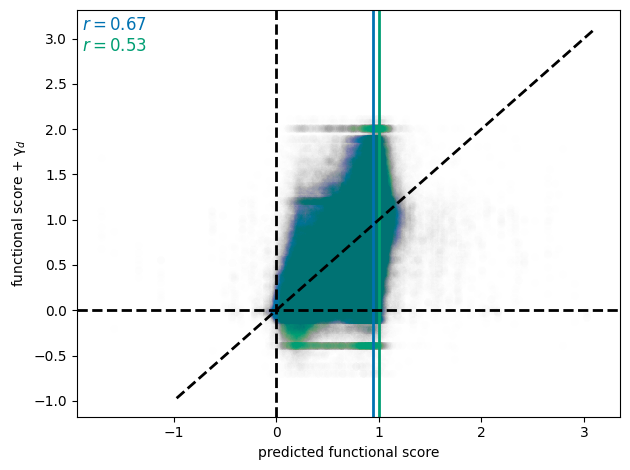

In [348]:
fig, ax = plt.subplots()
fit.loc[0, "model_20000"].plot_pred_accuracy(legend=False, alpha=0.005, ax=ax, show=False)
plt.show()

In [423]:
fit_abun.loc[0, "model_20000"].mut_shift_plot(include_beta=False, times_seen_threshold=3)

/home/jgallowa/miniconda3/envs/multidms_toml/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)

In [421]:
chart.save("CYP.html")

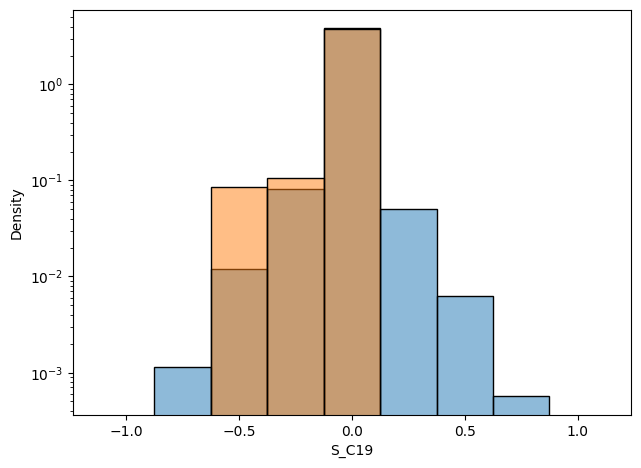

In [408]:
fig, ax = plt.subplots()
fit_abun.loc[0, "model_20000"].plot_param_hist("S_C19", ax=ax, show=False, )
ax.set_yscale("log")
plt.show()

In [339]:
fit_abun = copy.deepcopy(fit)

## Replicate Fits

In [353]:
func_score_df.query("condition == 'C9'").replicate.value_counts()

Rep2    48946
Rep3    48927
Rep1    45297
Name: replicate, dtype: int64

In [354]:
func_score_df.query("condition == 'C19'").replicate.value_counts()

Rep1    318813
Rep2    212375
Rep3    208772
Name: replicate, dtype: int64

In [357]:
fits = pd.DataFrame()

In [358]:
for replicate, replicate_df in func_score_df.groupby("replicate"):
    for lasso_shift in [2e-5, 2e-6]:
        data = multidms.MultiDmsData(
            replicate_df.rename({"abundance_score":"func_score"}, axis=1),
            reference = "C9",
            collapse_identical_variants = False,
            alphabet= multidms.AAS_WITHSTOP,
            verbose=True
        )
        data.condition_colors = {
            'C19': (0.0, 0.4470588235294118, 0.6980392156862745), 
            'C9': (0.0, 0.6196078431372549, 0.45098039215686275)
        }
        fit_params = {
            'epistatic_model' : "Identity",
            'output_activation' : "Identity",
            'lock_C_ref' : 1.,
            'gamma_corrected' : False,
            'warmup_beta':False,
            'save_model_at':[10000],
            'num_training_steps': 10,
            'iterations_per_step': 1000,
            'tol' : 1e-6,
            'λ_lasso_shift' : lasso_shift
        }
        start_t = time.time()
        fit = fit_wrapper(data, **fit_params)
        fit["replicate"] = replicate
        fits = pd.concat([fits, fit], ignore_index=True)
        end_t = time.time()

        print(f"Done")

inferring site map for C19
inferring site map for C9
INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Converting mutations for C19


Converting mutations for C9
is reference, skipping
running:
{'PRNGKey': 0,
 'conditional_c': False,
 'data_idx': 0,
 'dataset': <multidms.data.MultiDmsData object at 0x7f6ed0857eb0>,
 'epistatic_model': 'Identity',
 'gamma_corrected': False,
 'init_C_ref': 0.0,
 'iterations_per_step': 1000,
 'lock_C_ref': 1.0,
 'lock_beta': False,
 'num_training_steps': 10,
 'output_activation': 'Identity',
 'save_model_at': [10000],
 'step_loss': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'tol': 1e-06,
 'warmup_beta': False,
 'δ_huber': 1,
 'λ_lasso_shift': 2e-05,
 'λ_ridge_beta': 0,
 'λ_ridge_gamma': 0,
 'λ_ridge_shift': 0}
training_step 0/10, Loss: 0.3923227579336889, Time: 75 Seconds
training_step 1/10, Loss: 0.2976729953774493, Time: 70 Seconds
training_step 2/10, Loss: 0.2527027311824733, Time: 70 Seconds
training_step 3/10, Loss: 0.22696193177136945, Time: 70 Seconds
training_step 4/10, Loss: 0.2105518214836943, Time: 70 Seconds
training_step 5/10, Loss: 0.1995174663575048, Time: 69 Secon

Converting mutations for C9
is reference, skipping
running:
{'PRNGKey': 0,
 'conditional_c': False,
 'data_idx': 0,
 'dataset': <multidms.data.MultiDmsData object at 0x7f6f760000d0>,
 'epistatic_model': 'Identity',
 'gamma_corrected': False,
 'init_C_ref': 0.0,
 'iterations_per_step': 1000,
 'lock_C_ref': 1.0,
 'lock_beta': False,
 'num_training_steps': 10,
 'output_activation': 'Identity',
 'save_model_at': [10000],
 'step_loss': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'tol': 1e-06,
 'warmup_beta': False,
 'δ_huber': 1,
 'λ_lasso_shift': 2e-06,
 'λ_ridge_beta': 0,
 'λ_ridge_gamma': 0,
 'λ_ridge_shift': 0}
training_step 0/10, Loss: 0.38893453017200286, Time: 75 Seconds
training_step 1/10, Loss: 0.2938086131162282, Time: 70 Seconds
training_step 2/10, Loss: 0.24955519343853913, Time: 70 Seconds
training_step 3/10, Loss: 0.22437662789447543, Time: 70 Seconds
training_step 4/10, Loss: 0.20837508875848249, Time: 70 Seconds
training_step 5/10, Loss: 0.1975020705000421, Time: 70 Se

Converting mutations for C9
is reference, skipping
running:
{'PRNGKey': 0,
 'conditional_c': False,
 'data_idx': 0,
 'dataset': <multidms.data.MultiDmsData object at 0x7f6de1646410>,
 'epistatic_model': 'Identity',
 'gamma_corrected': False,
 'init_C_ref': 0.0,
 'iterations_per_step': 1000,
 'lock_C_ref': 1.0,
 'lock_beta': False,
 'num_training_steps': 10,
 'output_activation': 'Identity',
 'save_model_at': [10000],
 'step_loss': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'tol': 1e-06,
 'warmup_beta': False,
 'δ_huber': 1,
 'λ_lasso_shift': 2e-05,
 'λ_ridge_beta': 0,
 'λ_ridge_gamma': 0,
 'λ_ridge_shift': 0}
training_step 0/10, Loss: 0.32672042156048803, Time: 55 Seconds
training_step 1/10, Loss: 0.2242160836336238, Time: 51 Seconds
training_step 2/10, Loss: 0.1773897845627887, Time: 51 Seconds
training_step 3/10, Loss: 0.15039718614826494, Time: 51 Seconds
training_step 4/10, Loss: 0.13319729475212044, Time: 51 Seconds
training_step 5/10, Loss: 0.12154080874074195, Time: 51 Se

Converting mutations for C9
is reference, skipping
running:
{'PRNGKey': 0,
 'conditional_c': False,
 'data_idx': 0,
 'dataset': <multidms.data.MultiDmsData object at 0x7f6ebaadfeb0>,
 'epistatic_model': 'Identity',
 'gamma_corrected': False,
 'init_C_ref': 0.0,
 'iterations_per_step': 1000,
 'lock_C_ref': 1.0,
 'lock_beta': False,
 'num_training_steps': 10,
 'output_activation': 'Identity',
 'save_model_at': [10000],
 'step_loss': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'tol': 1e-06,
 'warmup_beta': False,
 'δ_huber': 1,
 'λ_lasso_shift': 2e-06,
 'λ_ridge_beta': 0,
 'λ_ridge_gamma': 0,
 'λ_ridge_shift': 0}
training_step 0/10, Loss: 0.32098748979906605, Time: 54 Seconds
training_step 1/10, Loss: 0.22029502860491276, Time: 51 Seconds
training_step 2/10, Loss: 0.17454345164088092, Time: 51 Seconds
training_step 3/10, Loss: 0.14836956593277353, Time: 51 Seconds
training_step 4/10, Loss: 0.1317395471365809, Time: 51 Seconds
training_step 5/10, Loss: 0.12042763588223436, Time: 51 S

Converting mutations for C9
is reference, skipping
running:
{'PRNGKey': 0,
 'conditional_c': False,
 'data_idx': 0,
 'dataset': <multidms.data.MultiDmsData object at 0x7f6ed0ab5d80>,
 'epistatic_model': 'Identity',
 'gamma_corrected': False,
 'init_C_ref': 0.0,
 'iterations_per_step': 1000,
 'lock_C_ref': 1.0,
 'lock_beta': False,
 'num_training_steps': 10,
 'output_activation': 'Identity',
 'save_model_at': [10000],
 'step_loss': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'tol': 1e-06,
 'warmup_beta': False,
 'δ_huber': 1,
 'λ_lasso_shift': 2e-05,
 'λ_ridge_beta': 0,
 'λ_ridge_gamma': 0,
 'λ_ridge_shift': 0}
training_step 0/10, Loss: 0.35160754025344615, Time: 55 Seconds
training_step 1/10, Loss: 0.25292943338840496, Time: 51 Seconds
training_step 2/10, Loss: 0.20923191414430004, Time: 50 Seconds
training_step 3/10, Loss: 0.18392286580556366, Time: 50 Seconds
training_step 4/10, Loss: 0.1676923273579393, Time: 50 Seconds
training_step 5/10, Loss: 0.15667847443948715, Time: 50 S

Converting mutations for C9
is reference, skipping
running:
{'PRNGKey': 0,
 'conditional_c': False,
 'data_idx': 0,
 'dataset': <multidms.data.MultiDmsData object at 0x7f6d80a1d1e0>,
 'epistatic_model': 'Identity',
 'gamma_corrected': False,
 'init_C_ref': 0.0,
 'iterations_per_step': 1000,
 'lock_C_ref': 1.0,
 'lock_beta': False,
 'num_training_steps': 10,
 'output_activation': 'Identity',
 'save_model_at': [10000],
 'step_loss': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'tol': 1e-06,
 'warmup_beta': False,
 'δ_huber': 1,
 'λ_lasso_shift': 2e-06,
 'λ_ridge_beta': 0,
 'λ_ridge_gamma': 0,
 'λ_ridge_shift': 0}
training_step 0/10, Loss: 0.3461579505113529, Time: 54 Seconds
training_step 1/10, Loss: 0.24938650640965385, Time: 51 Seconds
training_step 2/10, Loss: 0.20673812245594508, Time: 51 Seconds
training_step 3/10, Loss: 0.18209818533689523, Time: 50 Seconds
training_step 4/10, Loss: 0.1663226337508104, Time: 50 Seconds
training_step 5/10, Loss: 0.15554253872015233, Time: 50 Se

In [359]:
fits

dataset δ_huber λ_lasso_shift  \
0  <multidms.data.MultiDmsData object at 0x7f6ed0...       1       0.00002   
1  <multidms.data.MultiDmsData object at 0x7f6f76...       1      0.000002   
2  <multidms.data.MultiDmsData object at 0x7f6de1...       1       0.00002   
3  <multidms.data.MultiDmsData object at 0x7f6eba...       1      0.000002   
4  <multidms.data.MultiDmsData object at 0x7f6ed0...       1       0.00002   
5  <multidms.data.MultiDmsData object at 0x7f6d80...       1      0.000002   

  λ_ridge_beta λ_ridge_shift λ_ridge_gamma data_idx epistatic_model  \
0            0             0             0        0        Identity   
1            0             0             0        0        Identity   
2            0             0             0        0        Identity   
3            0             0             0        0        Identity   
4            0             0             0        0        Identity   
5            0             0             0        0        Identity   

  output_activation lock_beta  ... init_C_ref warmup_beta       tol  \
0          Identity     False  ...        0.0       False  0.000001   
1          Identity     False  ...        0.0       False  0.000001   
2          Identity     False  ...        0.0       False  0.000001   
3          Identity     False  ...        0.0       False  0.000001   
4          Identity     False  ...        0.0       False  0.000001   
5          Identity     False  ...        0.0       False  0.000001   

  num_training_steps iterations_per_step save_model_at PRNGKey  \
0                 10                1000       [10000]       0   
1                 10                1000       [10000]       0   
2                 10                1000       [10000]       0   
3                 10                1000       [10000]       0   
4                 10                1000       [10000]       0   
5                 10                1000       [10000]       0   

                                           step_loss  \
0  [0.3923227579336889, 0.2976729953774493, 0.252...   
1  [0.38893453017200286, 0.2938086131162282, 0.24...   
2  [0.32672042156048803, 0.2242160836336238, 0.17...   
3  [0.32098748979906605, 0.22029502860491276, 0.1...   
4  [0.35160754025344615, 0.25292943338840496, 0.2...   
5  [0.34615795051135284, 0.24938650640965385, 0.2...   

                                         model_10000 replicate  
0  <multidms.model.MultiDmsModel object at 0x7f6e...      Rep1  
1  <multidms.model.MultiDmsModel object at 0x7f6e...      Rep1  
2  <multidms.model.MultiDmsModel object at 0x7f6e...      Rep2  
3  <multidms.model.MultiDmsModel object at 0x7f6d...      Rep2  
4  <multidms.model.MultiDmsModel object at 0x7f6d...      Rep3  
5  <multidms.model.MultiDmsModel object at 0x7f6d...      Rep3  

[6 rows x 23 columns]

In [403]:
fits.loc[2].model_10000.mut_shift_plot(include_beta=False, times_seen_threshold=3)

/home/jgallowa/miniconda3/envs/multidms_toml/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)

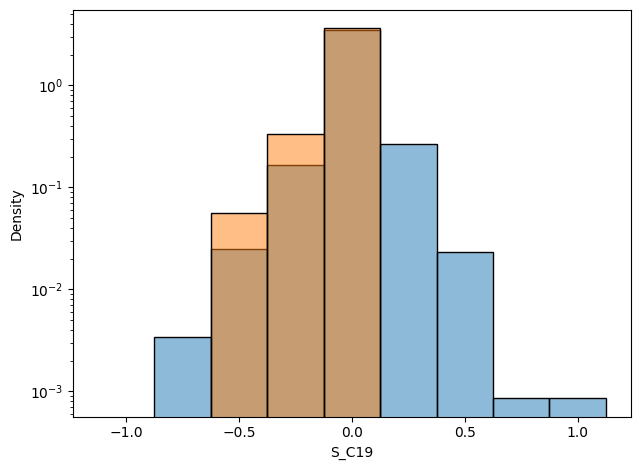

In [414]:
fig, ax = plt.subplots()
fits.loc[2].model_10000.plot_param_hist("S_C19", ax=ax, show=False, times_seen_threshold=3)
ax.set_yscale("log")
plt.show()

In [404]:
fits.loc[3].model_10000.mut_shift_plot(include_beta=False, times_seen_threshold=3)

/home/jgallowa/miniconda3/envs/multidms_toml/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)

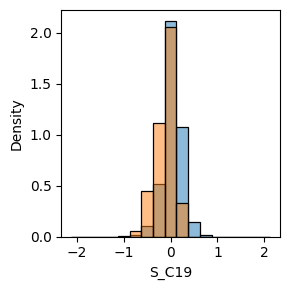

<AxesSubplot: xlabel='S_C19', ylabel='Density'>

In [405]:
fits.loc[3].model_10000.plot_param_hist("S_C19")

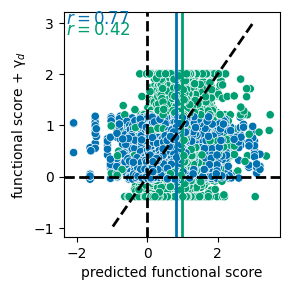

<AxesSubplot: xlabel='predicted functional score', ylabel='functional score + γ$_{d}$'>

In [368]:
fits.loc[0].model_10000.plot_pred_accuracy(legend=False)

In [375]:
fits.loc[1].model_10000.mut_shift_plot(include_beta=False, times_seen_threshold=10)

/home/jgallowa/miniconda3/envs/multidms_toml/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)

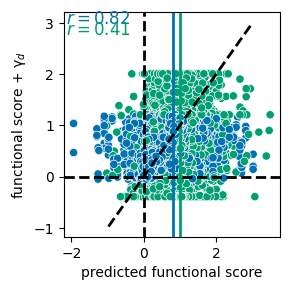

<AxesSubplot: xlabel='predicted functional score', ylabel='functional score + γ$_{d}$'>

In [367]:
fits.loc[1].model_10000.plot_pred_accuracy(legend=False)

In [370]:
fits

dataset δ_huber λ_lasso_shift  \
0  <multidms.data.MultiDmsData object at 0x7f6ed0...       1       0.00002   
1  <multidms.data.MultiDmsData object at 0x7f6f76...       1      0.000002   
2  <multidms.data.MultiDmsData object at 0x7f6de1...       1       0.00002   
3  <multidms.data.MultiDmsData object at 0x7f6eba...       1      0.000002   
4  <multidms.data.MultiDmsData object at 0x7f6ed0...       1       0.00002   
5  <multidms.data.MultiDmsData object at 0x7f6d80...       1      0.000002   

  λ_ridge_beta λ_ridge_shift λ_ridge_gamma data_idx epistatic_model  \
0            0             0             0        0        Identity   
1            0             0             0        0        Identity   
2            0             0             0        0        Identity   
3            0             0             0        0        Identity   
4            0             0             0        0        Identity   
5            0             0             0        0        Identity   

  output_activation lock_beta  ... init_C_ref warmup_beta       tol  \
0          Identity     False  ...        0.0       False  0.000001   
1          Identity     False  ...        0.0       False  0.000001   
2          Identity     False  ...        0.0       False  0.000001   
3          Identity     False  ...        0.0       False  0.000001   
4          Identity     False  ...        0.0       False  0.000001   
5          Identity     False  ...        0.0       False  0.000001   

  num_training_steps iterations_per_step save_model_at PRNGKey  \
0                 10                1000       [10000]       0   
1                 10                1000       [10000]       0   
2                 10                1000       [10000]       0   
3                 10                1000       [10000]       0   
4                 10                1000       [10000]       0   
5                 10                1000       [10000]       0   

                                           step_loss  \
0  [0.3923227579336889, 0.2976729953774493, 0.252...   
1  [0.38893453017200286, 0.2938086131162282, 0.24...   
2  [0.32672042156048803, 0.2242160836336238, 0.17...   
3  [0.32098748979906605, 0.22029502860491276, 0.1...   
4  [0.35160754025344615, 0.25292943338840496, 0.2...   
5  [0.34615795051135284, 0.24938650640965385, 0.2...   

                                         model_10000 replicate  
0  <multidms.model.MultiDmsModel object at 0x7f6e...      Rep1  
1  <multidms.model.MultiDmsModel object at 0x7f6e...      Rep1  
2  <multidms.model.MultiDmsModel object at 0x7f6e...      Rep2  
3  <multidms.model.MultiDmsModel object at 0x7f6d...      Rep2  
4  <multidms.model.MultiDmsModel object at 0x7f6d...      Rep3  
5  <multidms.model.MultiDmsModel object at 0x7f6d...      Rep3  

[6 rows x 23 columns]

In [381]:
fit_dict = {
    f"{r}":rep_df.reset_index().loc[0,"model_10000"]
    for r, rep_df in fits.query("λ_lasso_shift==2e-5").groupby("replicate")
}

In [415]:
combined_rep_mut_df = multidms.utils.combine_replicate_muts(fit_dict, times_seen_threshold=10)

In [416]:
combined_rep_mut_df

wts  sites muts    Rep1_β    Rep2_β    Rep3_β     avg_β  Rep1_S_C19  \
mutation                                                                       
D2G        D      2    G -0.075103 -0.109616 -0.088161 -0.090960    0.140758   
D2L        D      2    L  0.109715  0.170253 -0.070383  0.069862   -0.000000   
D2M        D      2    M -0.061554  0.027202 -0.151364 -0.061905    0.000000   
D2R        D      2    R -0.103993 -0.627938 -0.575181 -0.435704    0.000000   
D2S        D      2    S -0.037821 -0.081773  0.123670  0.001359    0.000000   
...       ..    ...  ...       ...       ...       ...       ...         ...   
S478R      S    478    R  0.084818  0.134486 -0.044100  0.058401    0.000000   
P480G      P    480    G -0.395757 -0.529245 -0.455769 -0.460257    0.046562   
F482L      F    482    L -0.152740 -0.107245 -0.115700 -0.125228    0.079049   
L485G      L    485    G -0.478303 -0.743615 -0.476318 -0.566079    0.115389   
L485V      L    485    V  0.024768  0.073281  0.057509  0.051853    0.009745   

          Rep2_S_C19  Rep3_S_C19  avg_S_C19  
mutation                                     
D2G         0.113991    0.082824   0.112524  
D2L        -0.000000    0.000000   0.000000  
D2M        -0.000000    0.000000   0.000000  
D2R         0.543933    0.590027   0.377987  
D2S         0.000000   -0.000000   0.000000  
...              ...         ...        ...  
S478R      -0.000000   -0.000000   0.000000  
P480G       0.000164    0.000000   0.015575  
F482L       0.000000    0.099266   0.059438  
L485G       0.219463    0.031691   0.122181  
L485V      -0.000000    0.000000   0.003248  

[991 rows x 11 columns]

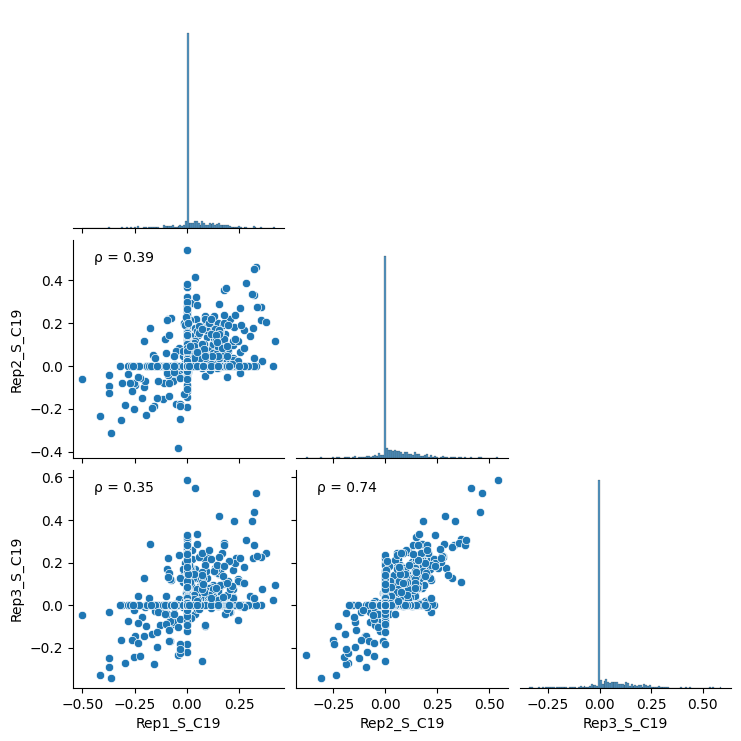

In [417]:
def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)
g = sns.pairplot(combined_rep_mut_df, vars=["Rep1_S_C19", "Rep2_S_C19","Rep3_S_C19"], corner=True)
g.map_lower(corrfunc)
plt.show()

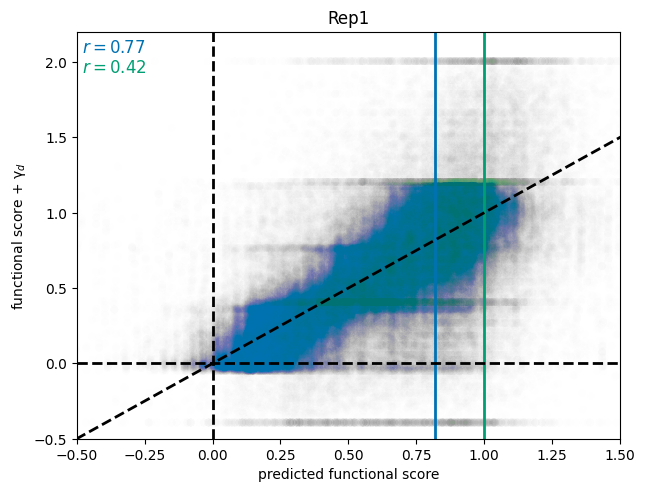

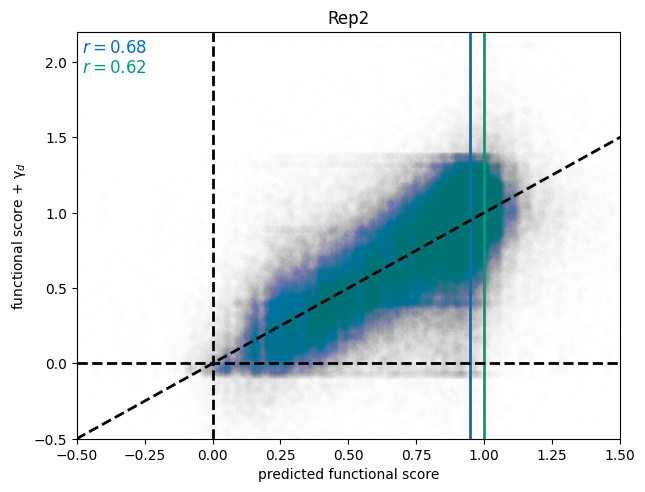

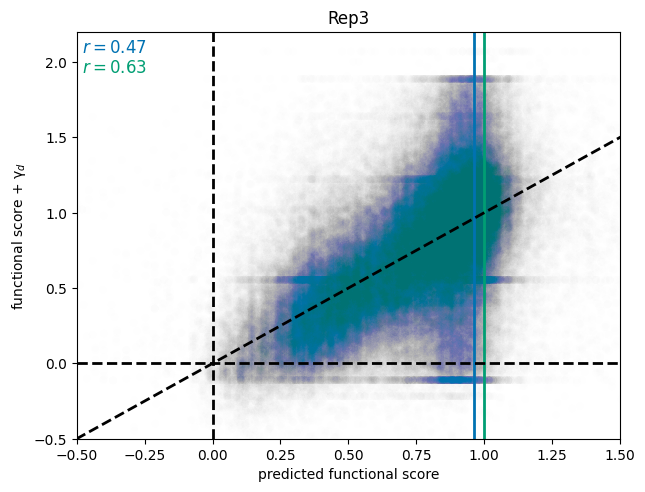

In [401]:
for rep, fit in fit_dict.items():
    fig, ax = plt.subplots()
    fit.plot_pred_accuracy(ax=ax, show=False, legend=False, alpha=0.003)
    ax.set_title(rep)
    ax.set_ylim([-.5, 2.2])
    ax.set_xlim([-0.5, 1.5])
    plt.show()

## Full Fit with log fold change of wa / wt_wa